# 计算物理B第七次作业--第二题

PB20511896 王金鑫

### 题目描述

用深度神经网络求解寻找超对称问题

- 使用单层隐藏神经元1000个，研究预言正确率与训练样本大小的关系，训练样本数目范围1000~4500000，画出关系图；
- 固定隐藏层神经元每层100个，研究正确率与隐藏层数的关系，层数范围1-5，画出关系图。

参考：https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB13_CIX-DNN_susy_Pytorch.html

数据集来源：https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

> 数据由MC方法生成。其中每个粒子有18个物理量特征，包括10个高级特征和8个低级特征，以及是否为超对称粒子的标签。
> 

### 设置随机数种子

这里使用当前时间作为随机数种子

In [13]:
# from __future__ import print_function, division
import time
import numpy as np
import torch  # pytorch package, allows using GPUs
# set seed
seed = int(time.time())
np.random.seed(seed)
torch.manual_seed(seed)


### 自定义数据集

定义一个SUSY数据集类，继承于`torch.utils.data.Dataset`

- 将数据文件中的部分数据扔到数据集中，并划分为训练集和测试集
- 这里将0.8的数据划为训练集，0.2的划为测试集
- 可以选择只使用高级特征、低级特征，或同时使用两种特征
- 这里也给出了特征标签的列表

In [14]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']
        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']
        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")



    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample


### 定义加载数据的函数


In [15]:
def load_data(args):

    data_file = 'SUSY.csv'
    # root_dir = os.path.expanduser('~')+'/ML_review/SUSY_data/'
    root_dir = './'

    kwargs = {}  # CUDA arguments, if enabled
    if args.use_cuda:
        device = torch.device("cuda")

        kwargs = {'num_workers': 1,
                       'pin_memory': True}

    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file, root_dir, args.dataset_size,
                     train=True, high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file, root_dir, args.dataset_size,
                     train=False, high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


### 定义神经网络

- 当 `single_layer==True` 时，求解第一小题，即使用单个含1000神经元的隐藏层

- 当 `single_layer==False` 时，求解第二小题，即使用多个含100神经元的隐藏层，上限为5

In [16]:
import torch.nn as nn # construct NN
# implements forward and backward definitions of an autograd operation
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self,layers,single_layer=False,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        self.layers = layers
        self.single_layer = single_layer

        # an affine operation: y = Wx + b
        if single_layer==True:
            if high_level_feats is None:
                self.fc1 = nn.Linear(18, 1000) # all features
            elif high_level_feats:
                self.fc1 = nn.Linear(10, 1000) # high-level only
            else:
                self.fc1 = nn.Linear(8, 1000) # low-level only
                
            self.batchnorm1 = nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1)
            self.fc2 = nn.Linear(1000, 2)
        else:
            if high_level_feats is None:
                self.fc1 = nn.Linear(18, 100)  # all features
            elif high_level_feats:
                self.fc1 = nn.Linear(10, 100) # high-level only
            else:
                self.fc1 = nn.Linear(8, 100) # low-level only

            self.batchnorm1 = nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)
            self.batchnorm2 = nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)
            self.batchnorm3 = nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)
            self.batchnorm4 = nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)
            self.batchnorm5 = nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

            self.fc2 = nn.Linear(100, 100)
            self.fc3 = nn.Linear(100, 100)
            self.fc4 = nn.Linear(100, 100)
            self.fc5 = nn.Linear(100, 100)
            self.fc6 = nn.Linear(100, 2)


    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        if self.single_layer==True:
            # apply rectified linear unit
            x = F.relu(self.fc1(x))
            # apply dropout
            x=self.batchnorm1(x)
            x = F.dropout(x, training=self.training)

            # apply affine operation fc2
            x = self.fc2(x)
            # soft-max layer
            x = F.log_softmax(x, dim=1)
        else:
            x = F.relu(self.fc1(x))
            x=self.batchnorm1(x)
            x = F.dropout(x, training=self.training)
            if 1==self.layers:
                x = self.fc6(x)
                x = F.log_softmax(x, dim=1)
                return x

            x = F.relu(self.fc2(x))
            x=self.batchnorm2(x)
            x = F.dropout(x, training=self.training)
            if 2==self.layers:
                x = self.fc6(x)
                x = F.log_softmax(x, dim=1)
                return x

            x = F.relu(self.fc3(x))
            x = self.batchnorm1(x)
            x = F.dropout(x, training=self.training)
            if 3==self.layers:
                x = self.fc6(x)
                x = F.log_softmax(x, dim=1)
                return x

            x = F.relu(self.fc4(x))
            x = self.batchnorm2(x)
            x = F.dropout(x, training=self.training)
            if 4==self.layers:
                x = self.fc6(x)
                x = F.log_softmax(x, dim=1)
                return x

            x = F.relu(self.fc5(x))
            x = self.batchnorm1(x)
            x = F.dropout(x, training=self.training)
            x = self.fc6(x)
            x = F.log_softmax(x,dim=1)
            
        return x
        


### 定义模型评估函数

将训练和测试整合，最后输出模型的测试结果

In [17]:
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(layers=args.layers,single_layer=args.single_layer,high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))
    if args.use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label.long())
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label.long(), size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]


### 定义结果绘图函数

两个函数分别用图像将两个小题的结果展示出来

In [18]:
import matplotlib.pyplot as plt

def plot_data1(x,y):

    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x,y)
    ax.set_xlabel('data sizes')
    ax.set_ylabel('accuracy')
    plt.show()


def plot_data2(x, y):

    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y)
    ax.set_xlabel('number of layers')
    ax.set_ylabel('accuracy')
    plt.show()


### 定义SGD训练函数

使用随机梯度下降法（SGD）来训练模型

下面两个函数分别对应两个小题

- 将1000~4500000等间隔地划分为5个作为第一小题的数据集大小
- 第二小题的数据集大小固定为200000

In [19]:
def grid_search1(args):

    dataset_sizes = np.linspace(1000, 4500000, 5, dtype=int)

    # pre-alocate data
    test_loss = np.zeros(len(dataset_sizes), dtype=np.float64)
    test_accuracy = np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size = dataset_size
        args.batch_size = int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        print("\n training DNN with %d data points. \n" %dataset_size)

        test_loss[i], test_accuracy[i] = evaluate_model(
            args, train_loader, test_loader)

    plot_data1(dataset_sizes, test_accuracy)


In [20]:
def grid_search2(args):

    layers_nums = np.linspace(1, 5, 5)

    # pre-alocate data
    test_loss = np.zeros(len(layers_nums), dtype=np.float64)
    test_accuracy = np.zeros_like(test_loss)

    # do grid search
    # upate data set size parameters
    args.dataset_size = 200000
    args.batch_size = int(2000)
    # load data
    train_loader, test_loader = load_data(args)

    for i, layers_num in enumerate(layers_nums):
        args.layers = layers_num
        print("\n training DNN with %d layers. \n" %layers_num)

        test_loss[i], test_accuracy[i] = evaluate_model(
            args, train_loader, test_loader)

    plot_data2(layers_nums, test_accuracy)


### 进行训练

使用 `argparse` 整合输入参数，使该程序可以通过命令行来方便地个性化参数

其中默认的学习率为0.1

In [21]:
import argparse  # handles arguments
import sys
sys.argv = ['']
del sys  # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                    help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                    help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate (default: 0.1)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--layers', type=int, default=1, metavar='N',
                    help='number of layers of NN')
parser.add_argument('--single_layer', type=bool, default=False, metavar='HLF',
                    help='use 1000 or 100')
parser.add_argument('--use_cuda', type=bool, default=False, metavar='HLF',
                    help='use cuda or cpu')


_StoreAction(option_strings=['--use_cuda'], dest='use_cuda', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help='use cuda or cpu', metavar='HLF')

### 第一小问


Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with 1000 data points. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.762958
Train Epoch: 1 [100/800 (12%)]	Loss: 17.841774
Train Epoch: 1 [200/800 (25%)]	Loss: 20.325108
Train Epoch: 1 [300/800 (38%)]	Loss: 5.945452
Train Epoch: 1 [400/800 (50%)]	Loss: 24.140615
Train Epoch: 1 [500/800 (62%)]	Loss: 12.679227
Train Epoch: 1 [600/800 (75%)]	Loss: 62.166859
Train Epoch: 1 [700/800 (88%)]	Loss: 6.689935


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 10.9656, Accuracy: 127/200 (63.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 11.266635
Train Epoch: 2 [100/800 (12%)]	Loss: 13.048929
Train Epoch: 2 [200/800 (25%)]	Loss: 0.632492
Train Epoch: 2 [300/800 (38%)]	Loss: 13.456708
Train Epoch: 2 [400/800 (50%)]	Loss: 4.275938
Train Epoch: 2 [500/800 (62%)]	Loss: 9.510625
Train Epoch: 2 [600/800 (75%)]	Loss: 18.014854
Train Epoch: 2 [700/800 (88%)]	Loss: 5.799457

Test set: Average loss: 4.9244, Accuracy: 135/200 (67.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 8.331659
Train Epoch: 3 [100/800 (12%)]	Loss: 3.856112
Train Epoch: 3 [200/800 (25%)]	Loss: 3.943788
Train Epoch: 3 [300/800 (38%)]	Loss: 4.522349
Train Epoch: 3 [400/800 (50%)]	Loss: 0.018233
Train Epoch: 3 [500/800 (62%)]	Loss: 8.750836
Train Epoch: 3 [600/800 (75%)]	Loss: 11.190210
Train Epoch: 3 [700/800 (88%)]	Loss: 3.317886

Test set: Average loss: 1.2537, Accuracy: 149/200 (74.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 1.036048
Train Epoch: 4 [100/800 (12%)]	Loss

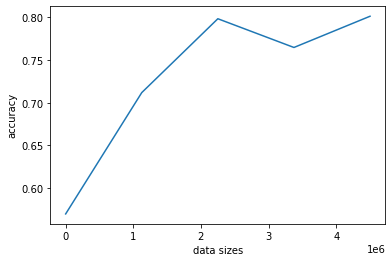

In [52]:

args = parser.parse_args('--single_layer=True'.split())

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search1(args)


### 第二小问


Training on 160000 examples
Using both high and low level features
Testing on 40000 examples
Using both high and low level features

 training DNN with 1 layers. 

Train Epoch: 1 [0/160000 (0%)]	Loss: 0.828741
Train Epoch: 1 [20000/160000 (12%)]	Loss: 0.528944
Train Epoch: 1 [40000/160000 (25%)]	Loss: 0.507554
Train Epoch: 1 [60000/160000 (38%)]	Loss: 0.488948
Train Epoch: 1 [80000/160000 (50%)]	Loss: 0.481229
Train Epoch: 1 [100000/160000 (62%)]	Loss: 0.479708
Train Epoch: 1 [120000/160000 (75%)]	Loss: 0.469301
Train Epoch: 1 [140000/160000 (88%)]	Loss: 0.462600


c:\Users\Bruce_Wong\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4464, Accuracy: 31815/40000 (79.537%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.458606
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.460160
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.463563
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.470462
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.451369
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.473385
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.467879
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.471058

Test set: Average loss: 0.4398, Accuracy: 31929/40000 (79.823%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.465234
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.454747
Train Epoch: 3 [40000/160000 (25%)]	Loss: 0.449576
Train Epoch: 3 [60000/160000 (38%)]	Loss: 0.446043
Train Epoch: 3 [80000/160000 (50%)]	Loss: 0.464570
Train Epoch: 3 [100000/160000 (62%)]	Loss: 0.438979
Train Epoch: 3 [120000/160000 (75%)]	Loss: 0.459895
Train Epoch: 3 [140000/160000 (88%)]	Loss: 0.462744

Test set: Average loss: 0.4388, Accuracy: 31912/40000 (

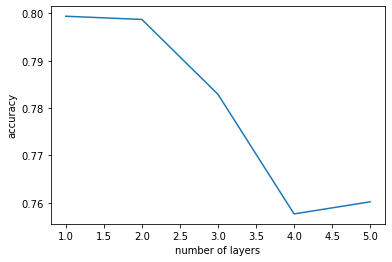

In [23]:
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search2(args)
